In [1]:
import numpy as np
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, random_split
import torch
from torch import optim
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import logging
from evaluate import evaluate
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import OrderedDict

#from model.unet.unet_model import UNet
#from model.segnet.segnet_model import SegNet
#from torchvision.models.segmentation import deeplabv3_resnet101 as DeepLabv3
from model.ensemblenet_model import EnsembleNet


from utils.dice_score import dice_loss
from utils.data_load import KittiDataset
from torchsummaryX import summary

In [2]:
Val_Percent = 0.3
Scale_Percent = 1.0
Batch_Size = 8
learning_rate = 0.001
Pin_Memory = False
epochs = 10

#Image_Size = [384, 1242]
#Image_Size = [384, 1216]
Image_Size = [384,384]
Gradient_Clipping = 1.0

#Num_Class = 31
Num_Class = 200
Num_Channel = 3
amp = True

#Img_Path =  'etc/training/image_2'
#Mask_Path = 'etc/training/semantic'


#Img_Path =  'data/train/images'
#Mask_Path = 'data/train/labels'


Img_Path_train =  'etc/train/images'
Mask_Path_train = 'etc/train/masks'
Img_Path_val =  'etc/validation/images'
Mask_Path_val = 'etc/validation/masks'

Img_Path_train =  'data/train/images'
Mask_Path_train = 'data/train/labels'
Img_Path_val =  'data/validation/images'
Mask_Path_val = 'data/validation/labels'

save_checkpoint = False
checkpoint_dir = '../trained'
batch_size = Batch_Size

In [3]:
'''
dirImg = Path(Img_Path)
dirMask = Path(Mask_Path)
'''


dirImg_train = Path(Img_Path_train)
dirMask_train = Path(Mask_Path_train)
dirImg_val = Path(Img_Path_val)
dirMask_val = Path(Mask_Path_val)

dir_checkpoint = Path(checkpoint_dir)

In [4]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
        #A.RandomGamma(p=0.5),
        #A.RandomSnow(p=0.5),
        #A.RandomRain(p=0.5),
        #A.RandomFog(p=0.5),
        #A.RandomSunFlare(p=0.5),
        A.RandomShadow(p=0.5),
        #A.RandomToneCurve(p=0.5),
        #A.GaussNoise(p=0.5),
        #A.Emboss(p=0.5),  # IAAEmboss 대신 Emboss 사용
        #A.Perspective(p=0.5),  # IAAPerspective 대신 Perspective 사용
        #A.CLAHE(p=0.5)
])

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent)
#datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent, train_transform)
n_val = int(len(datasets) * Val_Percent)
n_train = len(datasets) - n_val
train_set, val_set = random_split(datasets, [n_train, n_val], generator=torch.Generator().manual_seed(0))

loader_args = dict(batch_size=Batch_Size, num_workers= os.cpu_count(), pin_memory=Pin_Memory)
train_loader = DataLoader(train_set, shuffle=True, drop_last = True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

In [6]:
dirImg_train = Path(Img_Path_train)
dirMask_train = Path(Mask_Path_train)
dirImg_val = Path(Img_Path_val)
dirMask_val = Path(Mask_Path_val)

dir_checkpoint = Path(checkpoint_dir)

#train_datasets =  KittiDataset(dirImg_train, dirMask_train, Image_Size, 'train', Scale_Percent, transform = train_transform)
train_datasets =  KittiDataset(dirImg_train, dirMask_train, Image_Size, 'train', Scale_Percent)
val_datasets =  KittiDataset(dirImg_val, dirMask_val, Image_Size, 'validation', Scale_Percent)
n_train = len(train_datasets)

loader_args = dict(batch_size=Batch_Size, num_workers= os.cpu_count(), pin_memory=Pin_Memory)
train_loader = DataLoader(train_datasets, shuffle=True, drop_last = True, **loader_args)
val_loader = DataLoader(val_datasets, shuffle=False, drop_last=True, **loader_args)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1449/1449 [00:00<00:00, 1587.26it/s]


#datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent)
#datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent, train_transform)
n_val = int(len(datasets) * Val_Percent)
n_train = len(datasets) - n_val
train_set, val_set = random_split(datasets, [n_train, n_val], generator=torch.Generator().manual_seed(0))

loader_args = dict(batch_size=Batch_Size, num_workers= os.cpu_count(), pin_memory=Pin_Memory)
train_loader = DataLoader(train_set, shuffle=True, drop_last = True, collate_fn = cus_collate_fn, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

In [7]:
model = EnsembleNet('unet', Num_Channel, Num_Class)
model = model.to(memory_format=torch.channels_last, device = device)

summary(model, torch.zeros(2,3,384,1242).to(device))

In [8]:
# deeplab model output shape torch.Size([4, 31, 38, 124])

In [9]:
# 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss()
global_step = 0

In [ ]:
# 5. Begin training
for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0
    with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
        for batch in train_loader:
            images, true_masks = batch['image'], batch['mask']

            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            true_masks = true_masks.to(device=device, dtype=torch.long)

            with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                masks_pred = model(images)
                if isinstance(masks_pred, OrderedDict):
                    masks_pred = masks_pred['out']
                             
                try:
                    mn_cls = model.n_classes
                except:
                    mn_cls = model.classifier[-1].out_channels
                    
                
                if mn_cls == 1:
                    loss = criterion(masks_pred.squeeze(1), true_masks.float())
                    loss += dice_loss(F.sigmoid(masks_pred.squeeze(1)), true_masks.float(), multiclass=False)
                else:
                    loss = criterion(masks_pred, true_masks)
                    loss += dice_loss(
                        F.softmax(masks_pred, dim=1).float(),
                        F.one_hot(true_masks, mn_cls).permute(0, 3, 1, 2).float(),
                        multiclass=True
                    )
                

            optimizer.zero_grad(set_to_none=True)
            grad_scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), Gradient_Clipping)
            grad_scaler.step(optimizer)
            grad_scaler.update()

            pbar.update(images.shape[0])
            global_step += 1
            epoch_loss += loss.item()


            # Evaluation round
            division_step = (n_train // (5 * batch_size))
            if division_step > 0:
                if global_step % division_step == 0:

                    val_score = evaluate(model, val_loader, device, amp)
                    
                    scheduler.step(val_score)

                    #logging.info('Validation Dice score: {}'.format(val_score))
                    print('Training Dice Loss: {}'.format(loss))
                    print('Validation Dice score: {}'.format(val_score))
                                
            
    if save_checkpoint:
        Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch + 1)))

Epoch 1/10:  20%|███████████████████████████████████████████████                                                                                                                                                                                          | 296/1464 [00:17<07:27,  2.61img/s]

Training Dice Loss: 2.404892683029175
Validation Dice score: 0.992549479007721


Epoch 1/10:  40%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                            | 584/1464 [00:31<05:40,  2.58img/s]

Training Dice Loss: 1.9007210731506348
Validation Dice score: 0.992549479007721


Epoch 1/10:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 864/1464 [00:35<00:08, 70.78img/s]

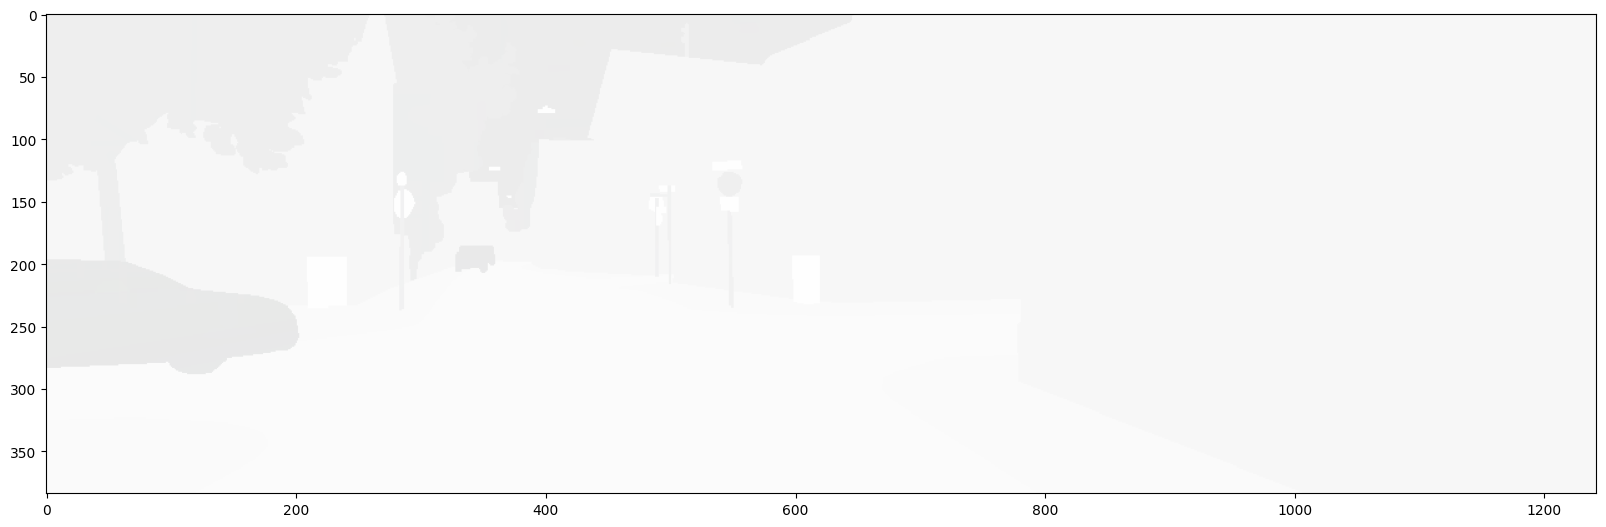

In [114]:
plt.figure(figsize = (20,10))
plt.imshow(true_masks.permute(1,2,0).cpu())

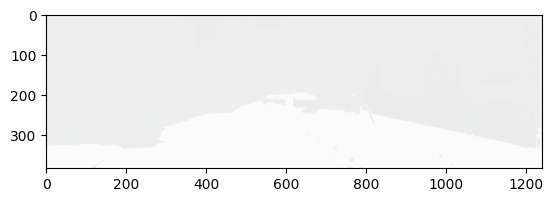

In [82]:
import matplotlib.pyplot as plt
plt.imshow(va2.cpu())

In [99]:
d = images.permute(0, 2, 3, 1)

In [100]:
d.shape

torch.Size([4, 384, 1242, 3])

In [138]:
dd = images.permute(1,2,3,0).cpu()[1]
#dd = np.array(dd).astype('uint8')

In [129]:
qq  =Image.open(Img_Path + '/' + '000085_10.png')

In [128]:
dd.shape

torch.Size([384, 1242, 4])

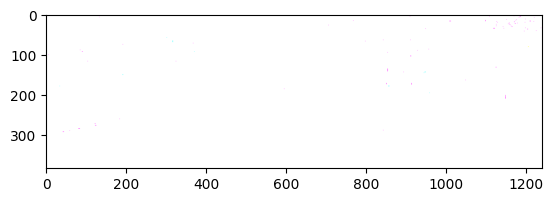

In [125]:
plt.imshow(dd)

In [ ]:
torch.max(masks_pred)

In [16]:
dd = torch.cat([masks_pred,masks_pred,masks_pred], dim = 1)

torch.Size([4, 93, 384, 1242])

In [17]:
out1 = nn.Conv2d(93, 31, kernel_size=3, padding=1)
out1 = out1.to(device)
out2 = nn.Conv2d(31, 31, kernel_size=3, padding=1)
out2 = out2.to(device)

In [20]:
dd2 = out1(dd)
dd3 = out2(dd2)

In [23]:
dd2.shape

torch.Size([4, 31, 384, 1242])

In [22]:
dd3.shape

torch.Size([4, 31, 384, 1242])

In [13]:
tensor1 = torch.randn(2, 31, 384, 1242)
tensor2 = torch.randn(2, 31, 384, 1242)

In [14]:

torch.cat((tensor1, tensor2), dim = 1).shape

torch.Size([2, 62, 384, 1242])